<a href="https://colab.research.google.com/github/SihaoCheng/scattering_transform/blob/master/ST_image_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import torch.nn as nn
import torch
import torch.optim as optim
import torch.fft as torch_fft

import time

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import ST_synthesis

save_dir = 'drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# Define bispectrum calculator

In [2]:
class Bispectrum_Calculator(object):
    def __init__(self, k_range, M, N, device='cpu'):
        self.device = device
        self.k_range = k_range
        self.M = M
        self.N = N
        X, Y = np.meshgrid(np.arange(M), np.arange(N))
        d = ((X-M//2)**2+(Y-N//2)**2)**0.5
        
        self.k_filters = np.zeros((len(k_range)-1, M, N), dtype=bool)
        for i in range(len(k_range)-1):
            self.k_filters[i,:,:] = np.fft.ifftshift((d<=k_range[i+1]) * (d>k_range[i]))
        self.k_filters_torch = torch.from_numpy(self.k_filters)
        refs = torch_fft.ifftn(self.k_filters_torch, dim=(-2,-1)).real
        
        self.select = torch.zeros(
            (len(self.k_range)-1, len(self.k_range)-1, len(self.k_range)-1), 
            dtype=bool
        )
        self.B_ref_array = torch.zeros(
            (len(self.k_range)-1, len(self.k_range)-1, len(self.k_range)-1),
            dtype=torch.float32
        )
        for i1 in range(len(self.k_range)-1):
            for i2 in range(i1+1):
                for i3 in range(i2+1):
                    if i2 + i3 >= i1 :
                        self.select[i1, i2, i3] = True
                        self.B_ref_array[i1, i2, i3] = (refs[i1] * refs[i2] * refs[i3]).mean()
        if device=='gpu':
            self.k_filters_torch = self.k_filters_torch.cuda()
            self.select = self.select.cuda()
            self.B_ref_array = self.B_ref_array.cuda()

        
    def forward(self, image):
        B_array = torch.zeros(
            (len(self.k_range)-1, len(self.k_range)-1, len(self.k_range)-1), 
            dtype=image.dtype
        )
        if self.device=='gpu':
            B_array = B_array.cuda()
        image_f = torch_fft.fftn(image, dim=(-2,-1))
        convs = torch_fft.ifftn(
            image_f[None,...] * self.k_filters_torch,
            dim=(-2,-1)
        ).real
        convs_std = convs.std((-1,-2))
        for i1 in range(len(self.k_range)-1):
            for i2 in range(i1+1):
                for i3 in range(i2+1):
                    if i2 + i3 >= i1 :
                        B = convs[i1] * convs[i2] * convs[i3]
                        B_array[i1, i2, i3] = B.mean() *1e8 # / self.B_ref_array[i1, i2, i3]
        return B_array[self.select]

# Define power spectrum calculator

In [3]:
def get_power_spectrum(target, bins, device='cpu'):
    '''
    get the power spectrum of a given image
    '''
    M, N = target.shape
    modulus = torch_fft.fftn(target, dim=(-2,-1)).abs()
    
    modulus = torch.cat(
        ( torch.cat(( modulus[M//2:, N//2:], modulus[:M//2, N//2:] ), 0),
          torch.cat(( modulus[M//2:, :N//2], modulus[:M//2, :N//2] ), 0)
        ),1)
    X = torch.arange(0,M)
    Y = torch.arange(0,N)
    Ygrid, Xgrid = torch.meshgrid(Y,X)
    R = ((Xgrid - M/2)**2 + (Ygrid - N/2)**2)**0.5

    R_range = torch.logspace(0.0, np.log10(1.4*M/2), bins)
    R_range = torch.cat((torch.tensor([0]), R_range))
    power_spectrum = torch.zeros(len(R_range)-1, dtype=target.dtype)
    if device=='gpu':
        R = R.cuda()
        R_range = R_range.cuda()
        power_spectrum = power_spectrum.cuda()

    for i in range(len(R_range)-1):
        select = (R >= R_range[i]) * (R < R_range[i+1])
        power_spectrum[i] = modulus[select].mean()
    return power_spectrum, R_range

# Define function to generate Gaussian fields

In [4]:
def get_random_data(target, M, N, mode='image'):
    '''
    get a gaussian random field with the same power spectrum as the image 'target' (in the 'image' mode),
    or with an assigned power spectrum function 'target' (in the 'func' mode).
    '''
    
    if mode == 'func':
        random_phase = np.random.normal(0,1,(M//2-1,N-1)) + np.random.normal(0,1,(M//2-1,N-1))*1j
        random_phase_left = (np.random.normal(0,1,(M//2-1)) + np.random.normal(0,1,(M//2-1))*1j)[:,None]
        random_phase_top = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_middle = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_corners = np.random.normal(0,1,3)
    if mode == 'image':
        random_phase = np.random.rand(M//2-1,N-1)
        random_phase_left = np.random.rand(M//2-1)[:,None]
        random_phase_top = np.random.rand(N//2-1)[None,:]
        random_phase_middle = np.random.rand(N//2-1)[None,:]
        random_phase_corners = np.random.randint(0,2,3)/2
    gaussian_phase = np.concatenate((
                      np.concatenate((random_phase_corners[1][None,None],
                                      random_phase_left,
                                      random_phase_corners[2][None,None],
                                      -random_phase_left[::-1,:],
                                    ),axis=0),
                      np.concatenate((np.concatenate((random_phase_top,
                                                      random_phase_corners[0][None,None],
                                                      -random_phase_top[:,::-1],
                                                    ),axis=1),
                                      random_phase, 
                                      np.concatenate((random_phase_middle, 
                                                      np.array(0)[None,None], 
                                                      -random_phase_middle[:,::-1],
                                                    ),axis=1), 
                                      -random_phase[::-1,::-1],
                                    ),axis=0),
                                    ),axis=1)
    

    if mode == 'image':
        gaussian_modulus = np.abs(np.fft.fftshift(np.fft.fft2(target)))
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*np.exp(1j*2*np.pi*gaussian_phase)))
    if mode == 'func':
        X = np.arange(0,M)
        Y = np.arange(0,N)
        Xgrid, Ygrid = np.meshgrid(X,Y)
        R = ((Xgrid-M/2)**2+(Ygrid-N/2)**2)**0.5
        gaussian_modulus = target(R)
        gaussian_modulus[M//2, N//2] = 0
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*gaussian_phase))
        
    data = np.fft.fftshift(np.real(gaussian_field))
    return data

# Define function of image synthesis

In [30]:
def image_synthesis(image, J, L, num_pixel,
                    learnable_param_list = [(100, 1e-3)],
                    savedir = '',
                    device='cpu',
                    coef = 'ST',
                    random_seed = 987,
                    low_bound = -0.010):

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    image = image[:num_pixel, :num_pixel]
    image_torch = torch.from_numpy(image).type(torch.FloatTensor) + 5
    if device=='gpu':
        image_torch = image_torch.cuda()
    
    target_bi = bispectrum_calculator.forward(image_torch)
    target_ST = ST_calculator.forward(image_torch[None,:,:], J, L)[0][0]
    target_ST = target_ST[target_ST!=0].log()
    target_PS, _ = get_power_spectrum(image_torch, 20, device)
    target_PS = target_PS.log()

#-------------------------------------------------------------------------------
    # define mock image
    class model_image(nn.Module):
        def __init__(self):
            super(model_image, self).__init__()

            # initialize with GRF of same PS as target image
            image_to_train = torch.from_numpy(
                get_random_data(image, num_pixel, num_pixel, "image").reshape(1,-1)*1
            ).type(torch.FloatTensor) + 5 + 0.000
            if device=='gpu':
                image_to_train = image_to_train.cuda()
            self.param = torch.nn.Parameter( image_to_train )
#-------------------------------------------------------------------------------
    model_fit = model_image()

    # define learnable
    for learnable_group in range(len(learnable_param_list)):
        num_step = learnable_param_list[learnable_group][0]
        learning_rate = learnable_param_list[learnable_group][1]
        
        # optimizer = optim.Adam(model_fit.parameters(), lr=learning_rate)
#         optimizer = optim.SGD(model_fit.parameters(), lr=learning_rate)
        optimizer = optim.Adamax(model_fit.parameters(), lr=learning_rate)

        # optimize
        for i in range(int(num_step)):
            # loss: power spectrum
            PS, _ = get_power_spectrum(model_fit.param.reshape(num_pixel,num_pixel), 20, device)
            PS = PS.log()
            loss_PS = ((target_PS - PS)**2).sum()
            # loss: L1
            target_L1 = (image_torch-5).abs().mean() 
            loss_L1 = (
                ((model_fit.param-5).abs().mean() - target_L1) / target_L1 
            )**2*1e6
            # loss: mean
            loss_mean = (
                model_fit.param.reshape(1,num_pixel,num_pixel).mean() - 
                image_torch.mean()
            )**2*1e7
            # loss: bound
            loss_bound = torch.exp(
                (5 + low_bound - model_fit.param.reshape(1,num_pixel,num_pixel))/0.003
            ).mean()

            if coef=='bi':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1

            if coef=='bi+P':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1 + loss_PS
                
            elif coef=='ST':
                ST = ST_calculator.forward(
                    model_fit.param.reshape(1,num_pixel,num_pixel), J, L,
                  )[0][0]
                ST = ST[ST!=0].log()
                loss_ST = ((target_ST - ST)**2).sum()*1000
                loss = loss_ST + loss_bound + loss_mean + loss_L1
            else:
                loss = loss_bound + loss_mean + loss_L1
                
            if i%100== 0:
                # save map
                # np.save(savedir + 'synthesis_results_step=' + str(i) + '.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                # np.save(savedir +'synthesis_results_final.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                print(i)
                print('loss: ',loss)
                print('loss_mean: ',loss_mean)
                print('loss_bound: ',loss_bound)
                print('loss_L1: ',loss_L1)
                if coef=='bi' or coef=='bi+P':
                    print('loss_bi: ',loss_bi)
                if coef=='bi+P':
                    print('loss_PS: ',loss_PS)
                if coef=='ST':
                    print('loss_ST: ',loss_ST)

            optimizer.zero_grad();
            loss.backward();
            optimizer.step();

    return model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5

# Load data & Create calculators

# Load target image

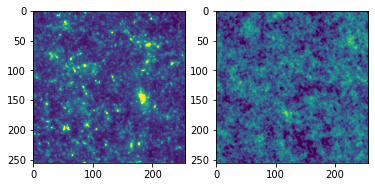

In [31]:
# load target image

save_dir = 'drive/My Drive/Colab Notebooks/'

M = 256
N = M
image = np.load('drive/My Drive/Colab Notebooks/H51_9.npy')[:M,:N]
plt.subplot(121)
plt.imshow(image, vmin=-0.03, vmax=0.1)
plt.subplot(122)
np.random.seed(989)
plt.imshow(get_random_data(image, M, N, mode='image'), vmin=-0.04, vmax=0.1)
plt.show()

# CPU / GPU

In [ ]:
device = 'gpu' # 'cpu'

# Generate wavelet filter bank

In [8]:
filter_set = ST_synthesis.FiltersSet(M=256, N=256, J=7, L=4)
filter_set.generate_morlet(if_save=True, save_dir=save_dir, precision='single')

# Create an ST calculator

In [7]:
J = 7
L = 4

filters_set = np.load(save_dir+'filters_set_mycode_M'+str(M)+
    'N'+str(N)+'J'+str(J)+'L'+str(L)+'_single.npy',
    allow_pickle=True)[0]['filters_set']

ST_calculator = ST_synthesis.ST_2D(filters_set, J, L, device=device)
image_torch = torch.from_numpy(image)[None,:,:]
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(2) 
start = time.time()
S,_,_,_ = ST_calculator.forward(image_torch, J, L)
print('% .4f s' % (time.time() - start))

 0.0640 s


In [8]:
S.shape

torch.Size([1, 204])

# Create a bispectrum calculator 

In [9]:
bin_edges = np.linspace(150/(360/3.5), M/2*1.4, 7) # in unit of pixel in Fourier space

bispectrum_calculator = Bispectrum_Calculator(bin_edges, M, N, device=device)
image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(1) 
start = time.time()
B = bispectrum_calculator.forward(image_torch)
print('% .4f s' % (time.time() - start))

 0.0157 s


In [10]:
B[:10]

tensor([1222.5204,   91.3163,   26.3665,   15.9117,   22.9145,    6.0671,
           2.4983,    4.0757,    1.5234,    5.9161], device='cuda:0')

# Test the power spectrum function

In [32]:
bins = 20
device = 'gpu'

image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

get_power_spectrum(image_torch, bins, device)

(tensor([53.3838, 93.8556, 41.9548, 83.6829, 44.1747, 64.8740, 50.9655, 45.3023,
         31.6566, 24.7657, 19.0566, 15.1125, 11.2181,  8.2779,  5.8608,  3.8872,
          2.4603,  1.4145,  0.7755,  0.4221], device='cuda:0'),
 tensor([  0.0000,   1.0000,   1.3140,   1.7266,   2.2688,   2.9812,   3.9173,
           5.1473,   6.7636,   8.8874,  11.6781,  15.3450,  20.1634,  26.4948,
          34.8143,  45.7461,  60.1106,  78.9856, 103.7874, 136.3771, 179.2000],
        device='cuda:0'))

# Run synthesis & Show result

0
loss:  tensor(9364078., device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(7924621.5000, device='cuda:0', grad_fn=<MeanBackward0>)
loss_L1:  tensor(28746.8242, device='cuda:0', grad_fn=<MulBackward0>)
loss_bi:  tensor(1410709.5000, device='cuda:0', grad_fn=<SumBackward0>)
loss_PS:  tensor(6.0212e-11, device='cuda:0', grad_fn=<SumBackward0>)
100
loss:  tensor(11363.9199, device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(6.0708, device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(11262.4883, device='cuda:0', grad_fn=<MeanBackward0>)
loss_L1:  tensor(0.7843, device='cuda:0', grad_fn=<MulBackward0>)
loss_bi:  tensor(92.3736, device='cuda:0', grad_fn=<SumBackward0>)
loss_PS:  tensor(2.2029, device='cuda:0', grad_fn=<SumBackward0>)
0
loss:  tensor(8805.6289, device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(5.2671, device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(8779.1436, de

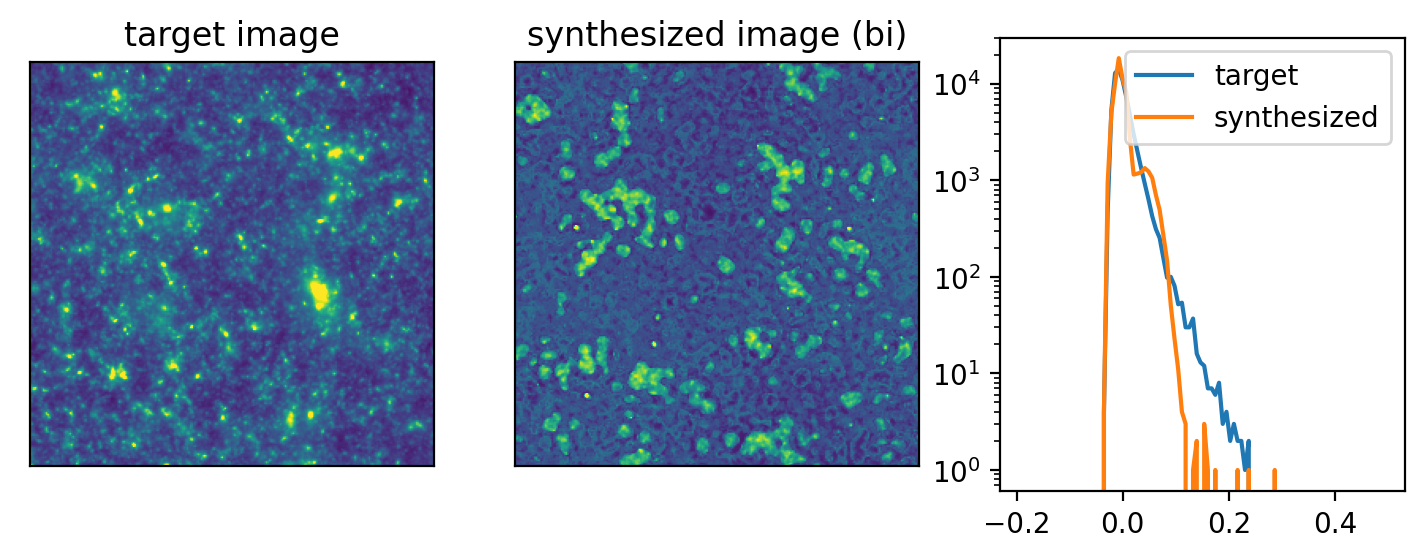

0.02026283 0.020285277


In [37]:
# synthesis

coef = 'bi+P'#'bi+P'
device = 'gpu'

for random_seed in [987]:
    # torch.set_num_threads(1) 
    synthesised_image = image_synthesis(
        image, J=J, L=L, num_pixel=M,
        learnable_param_list = [
            (100*2, 5e-3), (100*2, 1e-3), (100*1, 1e-3),
            (100*1, 5e-4), (100*1, 2e-4), (100*1, 1e-4), 
            # (100*1, 5e-5), (100*1, 2e-5), (100*1, 1e-5),
            # (100*1, 5e-6), (100*1, 2e-6), (100*1, 1e-6),
        ],
        savedir = save_dir,
        device = device,
        coef = coef,
        random_seed = random_seed,
        low_bound = -0.015,#-0.010,
    )
    # np.save(save_dir +'synthesis_results_final.npy', synthesised_image)
    
    synthesised_image = synthesised_image[0]
    plt.figure(figsize=(12,3),dpi=200)
    plt.subplot(141)
    plt.imshow(image, vmin=-0.04, vmax=0.10, )
    plt.title('target image')
    plt.xticks([]); plt.yticks([])

    plt.subplot(142)
    plt.imshow(synthesised_image, 
               vmin=-0.04, vmax=0.10, )
    plt.title('synthesized image (bi)')
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(143)
    y, x = np.histogram(image,  100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='target')
    y, x = np.histogram(synthesised_image,
                        100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='synthesized')
    plt.legend()
    plt.yscale('log')
    plt.show()
    print(image.std(),  synthesised_image.std())